# 1) Load Images

Before we can begin, we need to load and convert our 28 x 28 pixel PNG images into a machine readable format.

In [2]:
# Import necessary packages
import os
import struct
import numpy as np
from PIL import Image
import torch

# Import helpers
import matplotlib.pyplot as plt

## Convert our Images and Create Labels

First, we need to convert our PNG images and create labels for them.

The MNIST dataset uses images in a idx3-ubyte format and labels in idx1-ubyte format; therefore it seems reasonable to follow suit and convert ours to match.

In [6]:
# Function to convert image to numpy array (grayscale or RGB)
def image_to_array(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale (L mode)
    return np.array(image)

#write to idx3 for images and idx1 for labels
def write_idx(images, labels, output_image_file, output_label_file):
    # Write the images in IDX3 format
    with open(output_image_file, 'wb') as f:
        f.write(struct.pack(">I", 2051))  # Magic number for images (2051)
        
        # Number of images, rows, cols
        f.write(struct.pack(">I", len(images)))  # Number of images
        f.write(struct.pack(">I", 28))  # Rows and columns (28X28 image)
        f.write(struct.pack(">I", 28))
        
        for image in images:
            # Write each image as a flat byte array
            f.write(image.tobytes())
            
    # Write the labels in IDX3 format
    with open(output_label_file, 'wb') as f:
        # Magic number for labels
        f.write(struct.pack(">I", 2049))  # Magic number for labels (2049)
        
        # Number of labels
        f.write(struct.pack(">I", len(labels)))  # Number of labels
        
        for label in labels:
            # Write the label as a single byte
            f.write(struct.pack("B", label))

# Run our conversions for each image file
def convert(input_folder, output_image_file, output_label_file):
    images = []
    labels = []
    
    for filename in os.listdir(input_folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            # get label from Group5.Digits.<label char>_##.png
            label = filename[14]
            
            # opena nd convert to greyscale
            image = Image.open(os.path.join(input_folder, filename)).convert('L') 
            
            # Add image as array and add the label
            images.append(np.array(image))
            labels.append(int(label))
            
    # Convert to numpy array
    images = np.array(images)
    labels = np.array(labels)
    
     # Flatten images
    images = images.reshape(len(images), -1)
    
    # Write our new files for later usage
    write_idx(images, labels, output_image_file, output_label_file)

# File Paths
input_folder = "./image_files/digits/"
output_folder = "./train_data/"
output_image_file = os.path.join(output_folder, "Group5.Digits.Images.idx3-ubyte")
output_label_file = os.path.join(output_folder, "Group5.Digits.Labels.idx1-ubyte")

# Convert to IDX format
convert(input_folder, output_image_file, output_label_file)

## Visualize the Data

Just to show that everything works, we can now visualize the data from its IDX3 and IBX1 image and label formats.

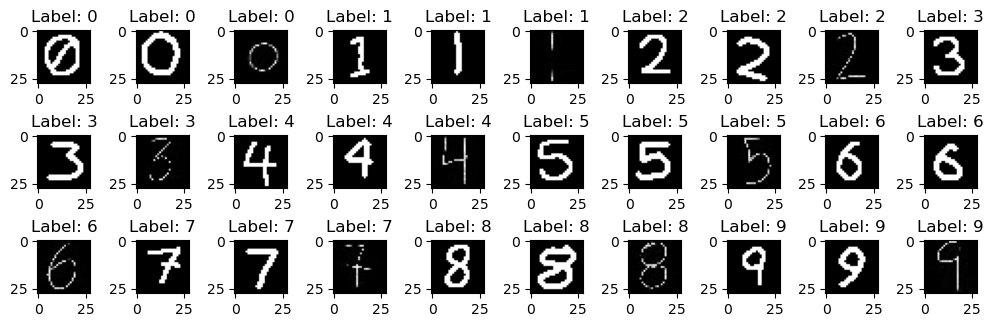

In [45]:
# Open the new idx3 file for images
def read_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
    return images

# Open the new idx1 file for labels
def read_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Call our functions and store our images and labels
images = read_images('./train_data/Group5.Digits.Images.idx3-ubyte')
labels = read_labels('./train_data/Group5.Digits.Labels.idx1-ubyte')

# Create variables for display
num_images = len(images)
num_cols = 10
num_rows = (num_images + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 1.1))
axes = axes.flatten()  

# Print our plot of images and labels
for i in range(num_images):
    ax = axes[i]  
    image = images[i].reshape(28, 28)  
    ax.imshow(image, cmap='gray')  
    ax.set_title(f"Label: {labels[i]}")  

plt.tight_layout()
plt.show()

# Training our Neural Net

First, prepare training data.

In [90]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print (trainloader)

## Backpropogation

NOT SURE IF CORRECT

In [91]:
x = torch.randn(3,3, requires_grad=True)
print("x:", x)

y = x**2
print("y:", y)

## grad_fn shows the function that generated this variable
print("y.grad_fn:", y.grad_fn)

y.retain_grad()

z = y.mean()
print("z:", z)

z.backward()
print("x.grad:", x.grad)
print("2*x/9:", 2*x/9)
print("y.grad:", y.grad)

x: tensor([[ 0.4665, -0.5527,  2.0274],
        [-0.3444,  0.8294, -1.0500],
        [-0.9392,  0.2906, -1.7759]], requires_grad=True)
y: tensor([[0.2176, 0.3054, 4.1104],
        [0.1186, 0.6879, 1.1025],
        [0.8821, 0.0844, 3.1539]], grad_fn=<PowBackward0>)
y.grad_fn: <PowBackward0 object at 0x0000018D0F1EF7C0>
z: tensor(1.1848, grad_fn=<MeanBackward0>)
x.grad: tensor([[ 0.1037, -0.1228,  0.4505],
        [-0.0765,  0.1843, -0.2333],
        [-0.2087,  0.0646, -0.3947]])
2*x/9: tensor([[ 0.1037, -0.1228,  0.4505],
        [-0.0765,  0.1843, -0.2333],
        [-0.2087,  0.0646, -0.3947]], grad_fn=<DivBackward0>)
y.grad: tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]])


## Loss and Autograd together

In [92]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128), # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10), # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008]])


## Training the network!

In [93]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model.parameters())
for parameter in model.parameters():
    print(parameter.shape)

<generator object Module.parameters at 0x0000018D0F217040>
torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [94]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784) # another way to flatten

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Initial weights -  Parameter containing:
tensor([[ 0.0320, -0.0118, -0.0099,  ..., -0.0179,  0.0071, -0.0114],
        [-0.0228, -0.0140, -0.0093,  ...,  0.0137, -0.0128,  0.0031],
        [-0.0060, -0.0249, -0.0114,  ..., -0.0250, -0.0167, -0.0012],
        ...,
        [-0.0111,  0.0353,  0.0288,  ..., -0.0134,  0.0328, -0.0337],
        [ 0.0145, -0.0127,  0.0209,  ...,  0.0328, -0.0147, -0.0035],
        [ 0.0103, -0.0094,  0.0208,  ..., -0.0138,  0.0303, -0.0124]],
       requires_grad=True)
Gradient - tensor([[ 2.3290e-05,  2.3290e-05,  2.3290e-05,  ...,  2.3290e-05,
          2.3290e-05,  2.3290e-05],
        [ 6.1540e-04,  6.1540e-04,  6.1540e-04,  ...,  6.1540e-04,
          6.1540e-04,  6.1540e-04],
        [ 1.5790e-04,  1.5790e-04,  1.5790e-04,  ...,  1.5790e-04,
          1.5790e-04,  1.5790e-04],
        ...,
        [-1.4390e-03, -1.4390e-03, -1.4390e-03,  ..., -1.4390e-03,
         -1.4390e-03, -1.4390e-03],
        [-3.9246e-05, -3.9246e-05, -3.9246e-05,  ..., -3.9246e

### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Final Project:** This is the training pass for our network. If implemented correctly, you should see the training loss drop with each epoch.

1. Training Pass, calculate loss
2. Backwards Pass
3. Update Weights

In [95]:
epochs = 5 # Number of training cycles
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in trainloader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")
    
print("Training complete!")

Epoch 1/5, Loss: 1.0002
Epoch 2/5, Loss: 0.3798
Epoch 3/5, Loss: 0.3220
Epoch 4/5, Loss: 0.2895
Epoch 5/5, Loss: 0.2660
Training complete!


Length of trainloader:938


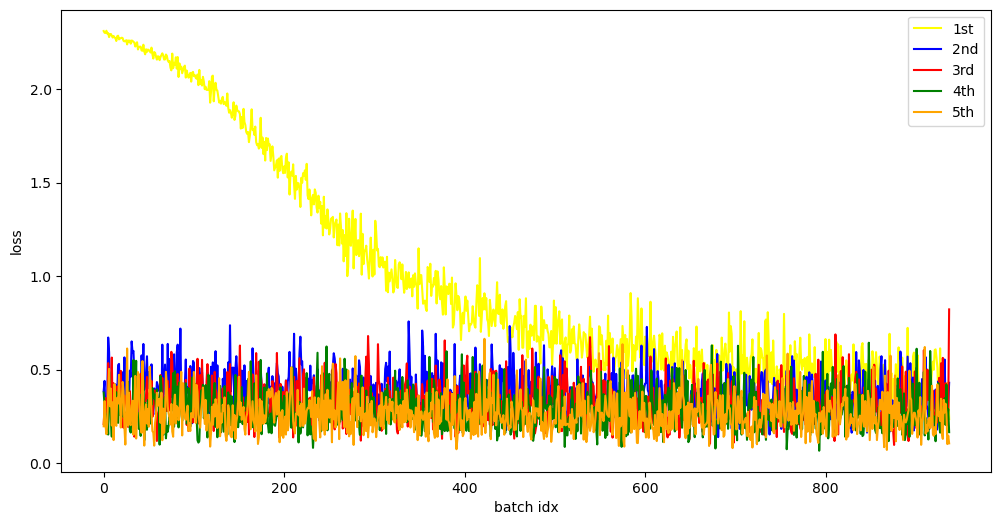

In [96]:
x = np.arange(len(trainloader))

print (f"Length of trainloader:{len(trainloader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

# Put it all together!

Epoch 1/5, Loss: 1.0086
Epoch 2/5, Loss: 0.3816
Epoch 3/5, Loss: 0.3239
Epoch 4/5, Loss: 0.2926
Epoch 5/5, Loss: 0.2683
Training complete!
Length of trainloader:938


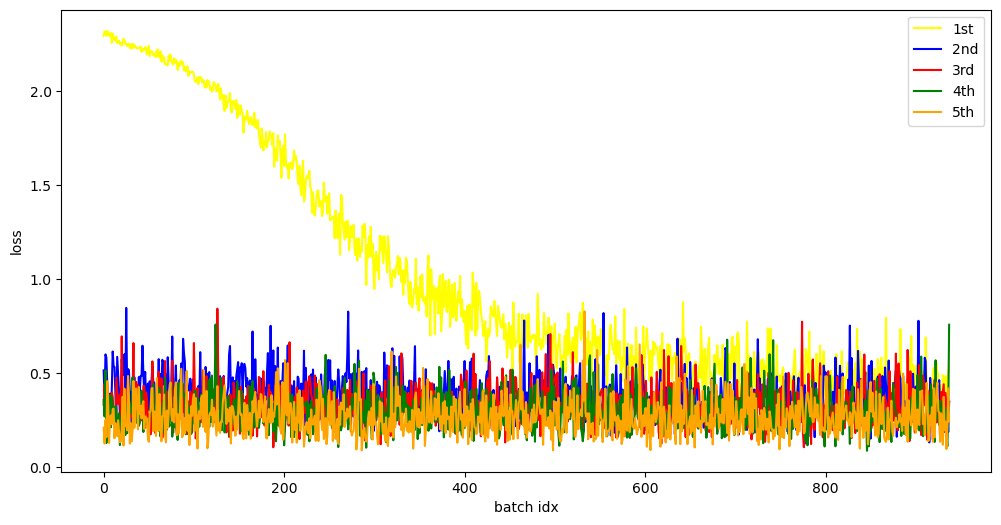

In [98]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)



## Loss and Autograd model
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128), # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10), # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

criterion = nn.NLLLoss()



## Training Loop
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)
images, labels = next(iter(trainloader))

epochs = 5 # Number of training cycles
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in trainloader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")
    
print("Training complete!")



## Print the visuals
x = np.arange(len(trainloader))

print (f"Length of trainloader:{len(trainloader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
# File Paths
input_folder = "./digits/"
output_folder = "./test_data/"
output_image_file = os.path.join(output_folder, "Class.Digits.Images.idx3-ubyte")
output_label_file = os.path.join(output_folder, "Class.Digits.Labels.idx1-ubyte")

images = []
labels = []

for filename in os.listdir(input_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        # get label from Group5.Digits.<label char>_##.png
        label = filename[0]
        
        # opena nd convert to greyscale
        image = Image.open(os.path.join(input_folder, filename)).convert('L') 
        image = np.array(image)
        if image.shape != (28, 28):
           print(f"Image {filename} is not 28x28, it has shape {image.shape}")
           print(f"Group {filename[2]}, shame on you!")
        image = image.resize((28, 28))
        # Add image as array and add the label
        images.append(image)
        labels.append(int(label))
        
# Convert to numpy array
images = np.array(images)
labels = np.array(labels)

    # Flatten images
images = images.reshape(len(images), -1)

# Write our new files for later usage
write_idx(images, labels, output_image_file, output_label_file)

Image 0-3-4.png is not 28x28, it has shape (26, 28)
Group 3, shame on you!
Image 2-3-4.png is not 28x28, it has shape (26, 28)
Group 3, shame on you!
Image 5-3-4.png is not 28x28, it has shape (28, 29)
Group 3, shame on you!
Image 6-3-4.png is not 28x28, it has shape (28, 29)
Group 3, shame on you!
Image 8-3-4.png is not 28x28, it has shape (28, 29)
Group 3, shame on you!
